In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow
from tensorflow.keras.layers import ReLU
import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

In [3]:
# Load the Kvasir dataset (assuming you have it in the 'data' directory)
# You may need to preprocess the data according to your specific use case
dataset_dir ="/content/drive/MyDrive/kvasir-dataset-v2/kvasir-dataset-v2"
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])


categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


,categorie,numbre of files
0,dyed-lifted-polyps,1000
1,dyed-resection-margins,1000
2,esophagitis,1000
3,normal-cecum,1000
4,normal-pylorus,1000
5,normal-z-line,1000
6,polyps,1000
7,ulcerative-colitis,1000


In [4]:
def create_dataset(datadir, categories, img_wid, img_high):

    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(X).reshape(y.shape[0], img_wid, img_wid, 3)
    return X, y


img_wid, img_high = 224, 224
X, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (8000, 224, 224, 3)
y: (8000,)


In [5]:
# Converting y to scaler format
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (6400, 224, 224, 3)
t_train: (6400, 1)
X_test: (1600, 224, 224, 3)
y_test: (1600, 1)


In [6]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(4480, 224, 224, 3),  y_train:(4480, 1)
x_train:(1920, 224, 224, 3),  y_train:(1920, 1)
x_train:(1600, 224, 224, 3),  y_train:(1600, 1)


In [7]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(4480, 224, 224, 3),  y_train:(4480, 8)
x_train:(1920, 224, 224, 3),  y_train:(1920, 8)
x_train:(1600, 224, 224, 3),  y_train:(1600, 8)


In [8]:
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
def xception_model(input_shape=(224, 224, 3), num_classes=1000):
  model = Sequential()

  # Input flow
  model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(ReLU())

  # Middle flow
  for _ in range(8):
    model.add(SeparableConv2D(128, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(SeparableConv2D(128, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

  # Exit flow
  model.add(SeparableConv2D(728, (3, 3), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(SeparableConv2D(1024, (3, 3), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(GlobalAveragePooling2D())

  # Fully connected layer
  model.add(Dense(num_classes, activation='softmax'))

  return model

In [9]:
# Define Xception base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape = (224,224,3)))
model.add(base_model)
model.add(Conv2D(filters=64,kernel_size =(4,4), input_shape=(4,4,2048) ))
model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(y_train.shape[1], activation=("softmax")))
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (None, 224, 224, 3)       12        
 chNormalization)                                                
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 64)          2097216   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 8)                 82

In [10]:
# Initialise no. of training samples for each batch
batch_size = 64

# No. of iterations
epochs = 10

# Learning rate
learn_rate = 0.001

# Using Gradient Descent
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

# Using adam optimizer
adam = Adam( learning_rate=learn_rate)

# Compiling the model
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])


In [11]:
lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)

In [12]:
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [13]:
mod = model.fit(
        # train_generator.flow(x_train, y_train, batch_size= batch_size),
        x_train,
        y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0],
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
         validation_steps=250,
        callbacks=[lrr],
        verbose=1,
    )

Epoch 1/10
4480/4480 [==============================] - ETA: 0s - loss: 1.3897 - accuracy: 0.4156

4480/4480 [==============================] - 202s 39ms/step - loss: 1.3897 - accuracy: 0.4156 - val_loss: 1.8455 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 2/10
4479/4480 [============================>.] - ETA: 0s - loss: 0.5160 - accuracy: 0.8075

4480/4480 [==============================] - 152s 34ms/step - loss: 0.5159 - accuracy: 0.8076 - lr: 0.0010
Epoch 3/10
4480/4480 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.8984

4480/4480 [==============================] - 153s 34ms/step - loss: 0.2759 - accuracy: 0.8984 - lr: 0.0010
Epoch 4/10
4480/4480 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9402

4480/4480 [==============================] - 153s 34ms/step - loss: 0.1719 - accuracy: 0.9402 - lr: 0.0010
Epoch 5/10
4480/4480 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9714

4480/4480 [==============================] - 153s 34ms/step - loss: 0.1021 - accuracy: 0.9714 - lr: 0.0010
Epoch 6/10
4480/4480 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9737

4480/4480 [==============================] - 151s 34ms/step - loss: 0.0785 - accuracy: 0.9737 - lr: 0.0010
Epoch 7/10
4480/4480 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9748

4480/4480 [==============================] - 158s 35ms/step - loss: 0.0786 - accuracy: 0.9748 - lr: 0.0010
Epoch 8/10
4479/4480 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9719

4480/4480 [==============================] - 153s 34ms/step - loss: 0.0918 - accuracy: 0.9719 - lr: 0.0010
Epoch 9/10
4480/4480 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9893

4480/4480 [==============================] - 153s 34ms/step - loss: 0.0386 - accuracy: 0.9893 - lr: 0.0010
Epoch 10/10
4479/4480 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9958

4480/4480 [==============================] - 152s 34ms/step - loss: 0.0144 - accuracy: 0.9958 - lr: 0.0010


In [14]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:

score = model.evaluate(x_test, y_test,verbose = 0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", (round(score[1], 3)))

Test loss: 2.345
Test accuracy: 0.936


In [16]:
mod = mod.history
mod.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

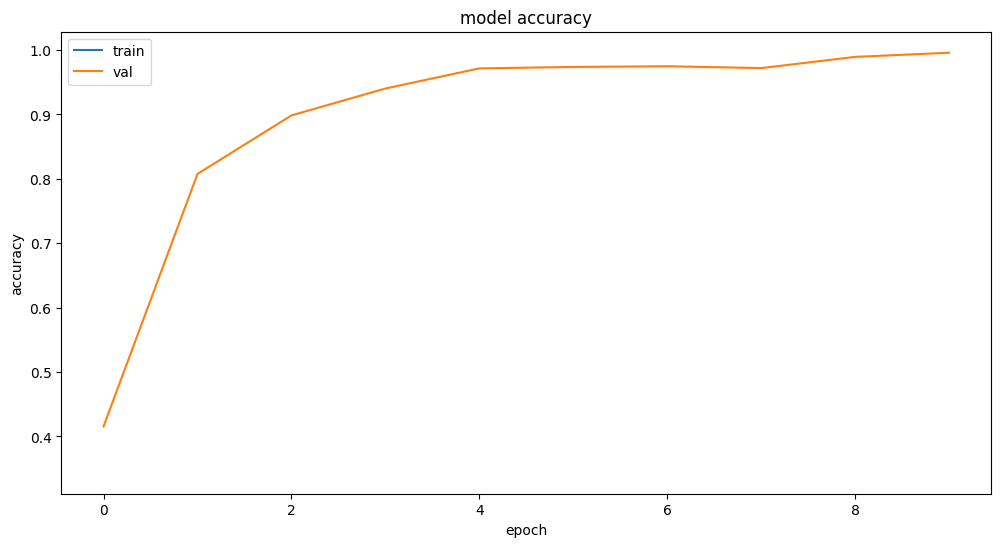

In [17]:
import matplotlib.pyplot as plt2
plt2.figure(figsize=(12, 6))
plt2.plot(mod['val_accuracy'])
plt2.plot(mod['accuracy'])
plt2.title('model accuracy')
plt2.ylabel('accuracy')
plt2.xlabel('epoch')
plt2.legend(['train', 'val'], loc='upper left')
plt2.show()

# New Section

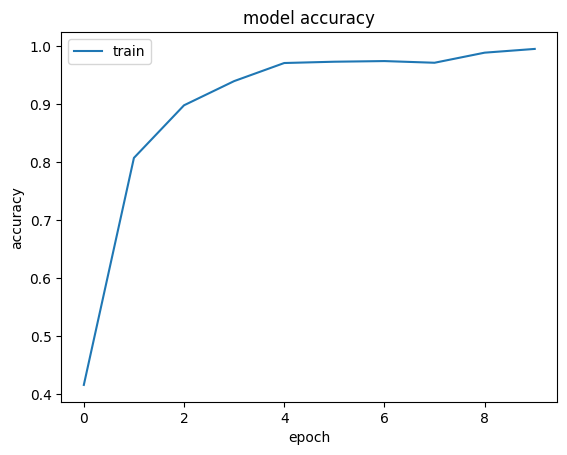

In [18]:
plt2.plot(mod['accuracy'])
plt2.title('model accuracy')
plt2.ylabel('accuracy')
plt2.xlabel('epoch')
plt2.legend(['train', 'val'], loc='upper left')
plt2.show()